# AntEpiSeeker analysis on Alanine content dataset

## Which kind of input format do we need to launch **AntEpiSeeker** utility?

`AntEpiSeeker` needs genotype in "012" format and binary phenotype:

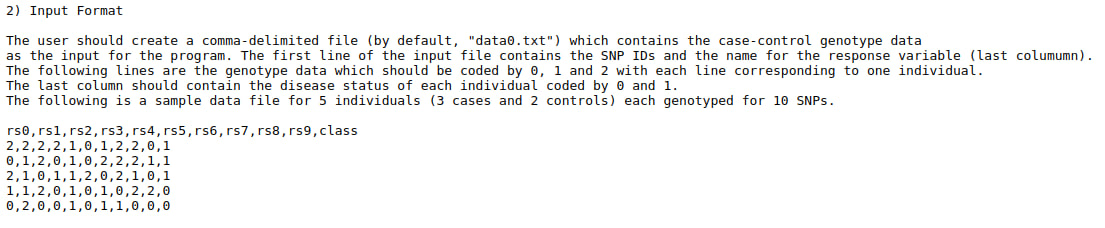

It is organized in such way:

1) *row* for each sample;
2) *column* for each SNP;
3) *genotypes encoded in "012"*, where the number represent that number of non-reference alleles. Missing genotypes are represented by -1;
4) the last *class* column stand for *phenotype* (usually discrete 0/1);
5) file should be comma-delimited

`VCFtools` v0.1.16 allows to convert `.vcf` to `.012`.

**NOTE**: For more information about `AntEpiSeeker`, see [README.md](./README.md), [the authors article](https://bmcresnotes.biomedcentral.com/articles/10.1186/1756-0500-3-117) and their [website](http://nce.ads.uga.edu/~romdhane/AntEpiSeeker/index.html).

In [1]:
! vcftools --vcf ../../data/soybean_aa_genotypes.vcf --012 --out ../ala_med_input/soybean_aa_genotypes


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../../data/soybean_aa_genotypes.vcf
	--012
	--out ../ala_med_input/soybean_aa_genotypes

After filtering, kept 249 out of 249 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 23278 out of a possible 23278 Sites
Run Time = 1.00 seconds


As the result, three **soybean_aa_genotypes** output files were generated: *.012* with the 012 matrix, *.012.indv* with sample names added to matrix, and *.012.pos* with chromosome positions for each SNP. **soybean_aa_genotypes.012.pos** file with SNP locations generated by `vcftools` was used to make indices for SNPs in 012 matrix (chr_N:pos).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
import requests

from parsing_ant import (parse_features, parse_string,
                     parse_snp_coord, generate_1kb_regions, 
                     generate_bed_file_aa, assign_gene_for_snp, 
                     parse_kegg_results)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading file with SNP coordinates to generate SNP IDs
snp_ids = pd.read_csv("../ala_med_input/soybean_aa_genotypes.012.pos", delimiter="\t", names=["chr", "pos"])

# to delete GLYMAX at the begining of chr
snp_ids['chr'] = snp_ids['chr'].str[5:]

# to combine str in chr and pos columns
snp_ids['SNP_ID'] = snp_ids[['chr', 'pos']].astype(str).agg(':'.join, axis=1)
snp_ids.head()

,chr,pos,SNP_ID
0,chr_01,41579,chr_01:41579
1,chr_01,69607,chr_01:69607
2,chr_01,93302,chr_01:93302
3,chr_01,123428,chr_01:123428
4,chr_01,123445,chr_01:123445


In [3]:
# SNP_IDs for column names in 012 matrix from snp_ids
col_names = list(snp_ids['SNP_ID'])

# reading 012 genotype file generated by VCFtools
soybean_012 = pd.read_csv("../ala_med_input/soybean_aa_genotypes.012", names=col_names, delimiter='\t')
soybean_012.head()

,chr_01:41579,chr_01:69607,chr_01:93302,chr_01:123428,chr_01:123445,chr_01:123647,chr_01:153438,chr_01:153686,chr_01:156795,chr_01:164083,...,chr_20:46573354,chr_20:46613166,chr_20:46656732,chr_20:46674070,chr_20:46692693,chr_20:46740364,chr_20:46740390,chr_20:46751278,chr_20:46751325,chr_20:46755301
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,2,2,2,2,2,2,2,2,...,2,0,0,0,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,2,2,2,2,-1,-1,2,2,2
4,2,2,2,2,2,2,2,2,2,2,...,0,2,2,2,2,2,2,2,2,2


### Checking missing genotype format

Missed values in `.vcf` file is in **./.** format. In *012* format it should be converted into *-1*. We manually checked initial `.vcf` file to find rows with missing genotypes. For example, there is missing variant **chr_01:41579** for **244** sample (index 243 in 0-based Python indexing). As expected, during convertion into *012* genotype it was replaced by **-1**.

In [4]:
# an example row (sample) with missing variant chr_01:41579
soybean_012.loc[[243]]

,chr_01:41579,chr_01:69607,chr_01:93302,chr_01:123428,chr_01:123445,chr_01:123647,chr_01:153438,chr_01:153686,chr_01:156795,chr_01:164083,...,chr_20:46573354,chr_20:46613166,chr_20:46656732,chr_20:46674070,chr_20:46692693,chr_20:46740364,chr_20:46740390,chr_20:46751278,chr_20:46751325,chr_20:46755301
243,-1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,2,2,0,2,0


### Combining genotype data with phenotype

In [5]:
# reading file with amino acide content (in our case, file with phenoty[e data)
soybean_phenotype = pd.read_csv("../../data/soybean_aa_phenotypes.tsv", delimiter='\t')
soybean_phenotype.head()

,FID,IID,Ala,Arg,Asp,Glu,Gly,His,Ile,Leu,Lys,Phe,Pro,Ser,Thr,Tyr,Val
0,HP202,HP202,17.1,28.7,44.5,71.9,16.8,10.6,18.0,29.3,25.3,20.1,22.5,19.2,15.2,13.2,19.3
1,L62-880,L62-880,16.3,25.7,45.0,76.9,14.8,9.2,16.5,26.3,22.2,17.8,19.7,18.3,15.4,12.0,17.4
2,Baiqidawandou,Baiqidawandou,17.9,23.9,44.3,75.6,15.3,9.2,17.1,27.0,22.4,17.6,18.2,19.1,16.5,12.7,19.1
3,L66-721,L66-721,16.4,25.2,44.6,75.7,15.1,9.2,16.1,26.1,22.3,17.8,20.4,18.2,15.6,11.7,17.2
4,L73-67,L73-67,16.8,26.2,46.6,79.8,15.3,9.5,16.6,27.0,22.8,18.5,20.3,19.6,16.4,12.4,17.5


We decided to visualize distribution of alanine content in our dataset.

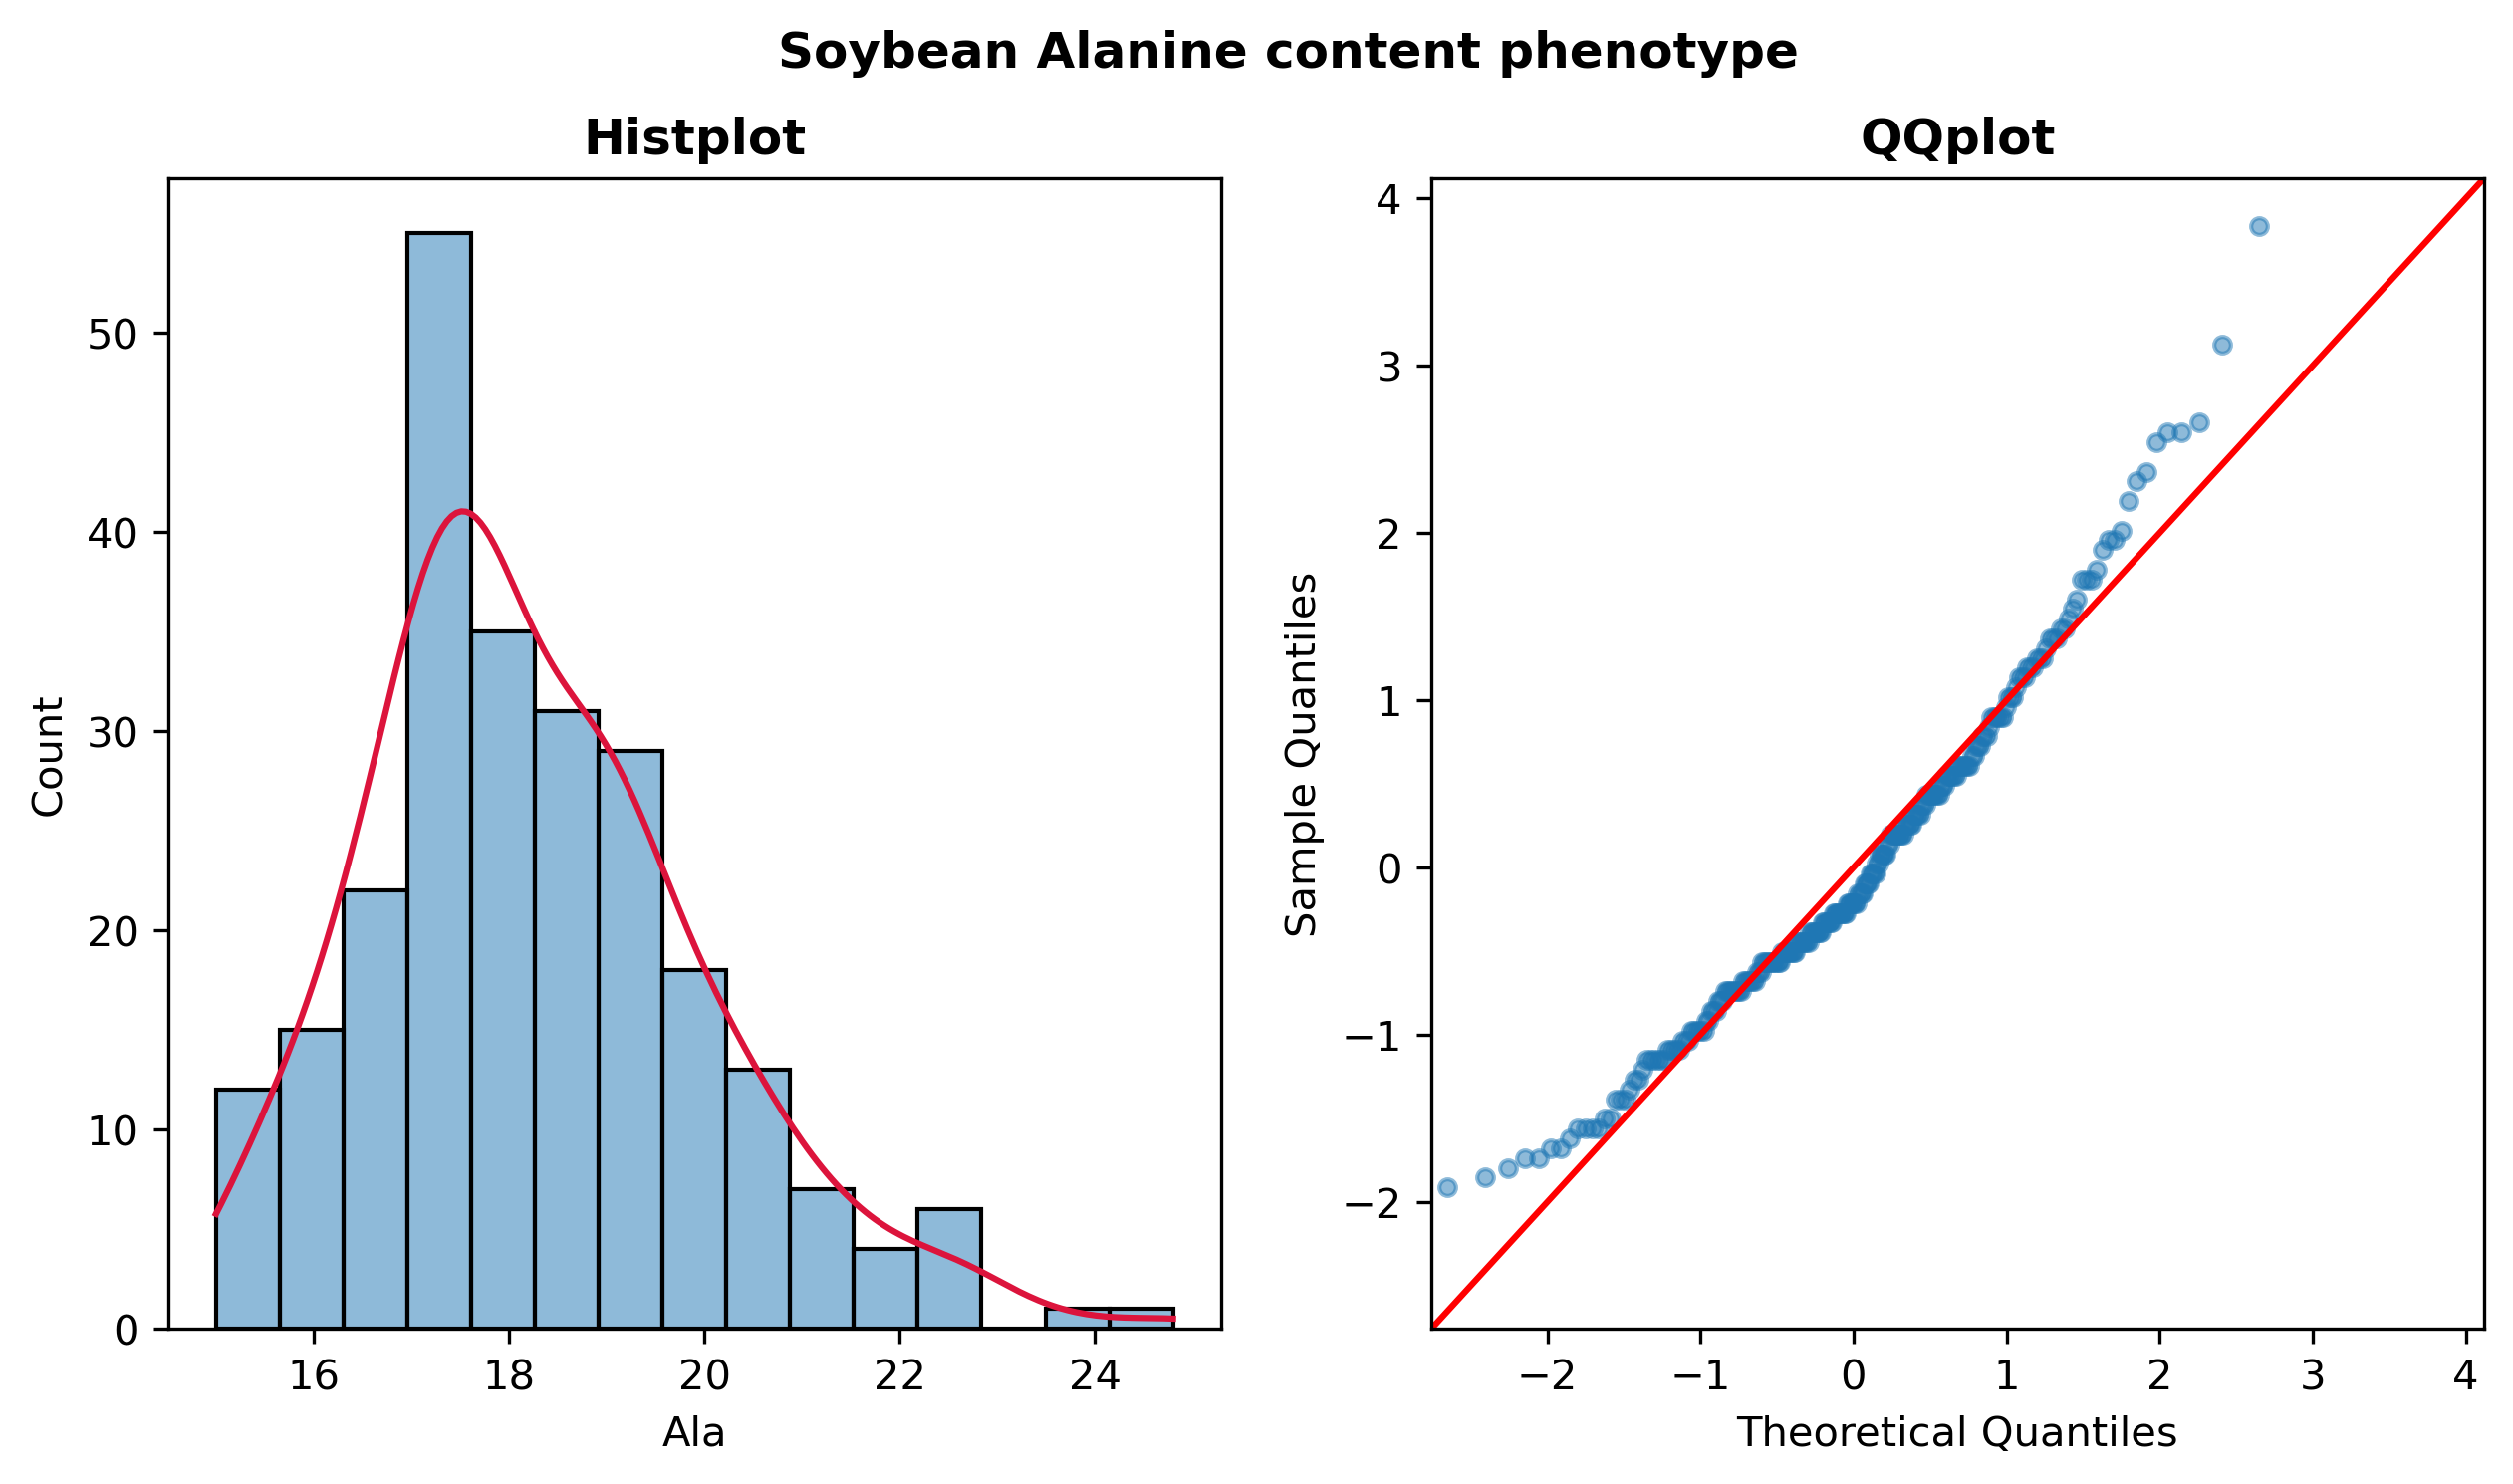

In [6]:
## histplot and qqplot for alanine phenotype
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5), dpi=300)

sns.histplot(soybean_phenotype["Ala"], kde=True, ax=axes[0])
axes[0].lines[0].set_color('crimson')
axes[0].set_title("Histplot", fontsize=12, fontweight='bold')
sm.qqplot(soybean_phenotype["Ala"], fit=True,
          line='45', ax=axes[1], alpha=0.5, markersize=4)
axes[1].set_title("QQplot", fontsize=12, fontweight='bold')
fig.suptitle("Soybean Alanine content phenotype", fontsize=12, fontweight='bold')
plt.show()

Unfortunately, only *qualitative phenotypes* could be analyzed with `AntEpiSeeker`. To tackle this obstacle, we converted *quantitative alanine content phenotype* into *binary* via calculating **the median value of amino acid content** and assigning *“0”* for samples with the value *less than median* and *“1” in the opposite case*.

- Firstly, we combined genotype with with **continuous** Ala phenotype:

In [7]:
# combining genotype with continuous phenotype data
soybean012_ala_cont = pd.concat([soybean_012, soybean_phenotype.Ala], axis=1)

# renaming phenotype column into "class", this is a requirement for `AntEpiSeeker` input file
soybean012_ala_cont.rename(columns={"Ala": "class"}, inplace=True)
soybean012_ala_cont.head()

,chr_01:41579,chr_01:69607,chr_01:93302,chr_01:123428,chr_01:123445,chr_01:123647,chr_01:153438,chr_01:153686,chr_01:156795,chr_01:164083,...,chr_20:46613166,chr_20:46656732,chr_20:46674070,chr_20:46692693,chr_20:46740364,chr_20:46740390,chr_20:46751278,chr_20:46751325,chr_20:46755301,class
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17.1
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16.3
2,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,2,0,17.9
3,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,-1,-1,2,2,2,16.4
4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,16.8


- Secondly, we removed the SNP column if it was skipped for at least in one sample. `AntEpiSeeker` does not work with files with missing genotypes:

In [8]:
# dropping SNP if any sample has not got it
mask = -(soybean012_ala_cont == -1).any()
soybean012_ala_med = soybean012_ala_cont.loc[:, mask]
soybean012_ala_med.shape

(249, 14700)

After dropping missing variants, we remained **14700 SNPs**.

- Thirdly, we generated dataset with **discrete** (*med amino acid content*) Ala phenotype (0: < median, 1: > median):

In [9]:
# median concentration for Ala
median_ala = soybean012_ala_cont["class"].median()
print(f"Median alanine content in samples: {median_ala}")

Median alanine content in samples: 17.9


In [10]:
# generating dataset with discrete Ala phenotype
soybean012_ala_med["class"] = soybean012_ala_med["class"].apply(
    lambda x: 0 if x <= median_ala else 1
)

# generating AntEpiSeeker input file
soybean012_ala_med.to_csv("../ala_med_input/soybean012_ala_med.csv", index=False)
soybean012_ala_med.head()

,chr_01:123428,chr_01:123445,chr_01:153438,chr_01:156795,chr_01:284285,chr_01:292130,chr_01:370048,chr_01:373238,chr_01:382396,chr_01:385187,...,chr_20:46528763,chr_20:46528791,chr_20:46560196,chr_20:46573298,chr_20:46573354,chr_20:46656732,chr_20:46751278,chr_20:46751325,chr_20:46755301,class
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,2,2,0,2,2,2,2,2,...,2,0,2,2,2,0,0,2,0,0
3,0,0,0,0,0,2,0,0,0,0,...,0,0,2,2,0,2,2,2,2,0
4,2,2,2,2,0,2,0,0,0,0,...,0,2,2,2,0,2,2,2,2,0


Also we checked abundance of each class (0 or 1) in generated input file.

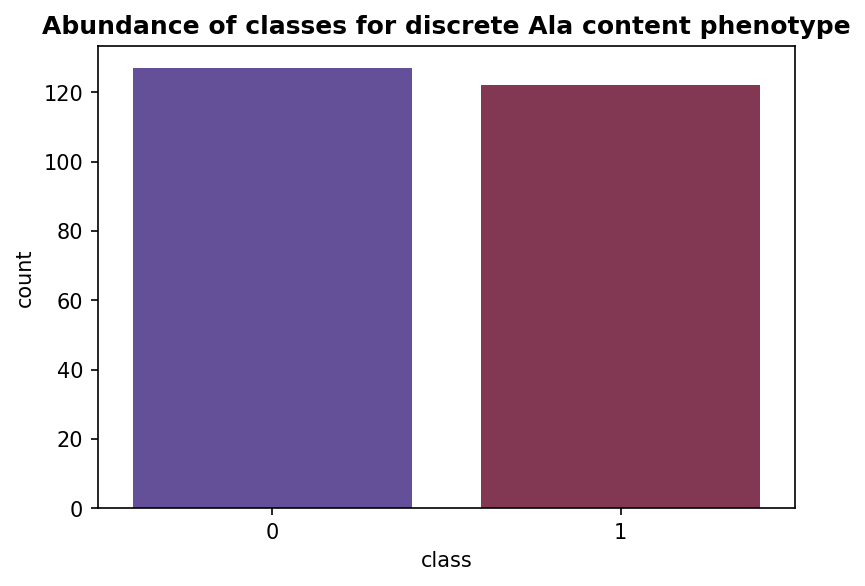

In [11]:
# countplot for an adundance of the classes
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
sns.countplot(soybean012_ala_med["class"], palette="twilight")
ax.set_title("Abundance of classes for discrete Ala content phenotype", fontweight="bold");

## Running **AntEpiSeeker**

### Two loci interaction mode

To run `AntEpiSeeker`, we should specify `parameters.txt` file. 

**NOTE**: For description of parameters see [README.md](../README.md) section **AntEpiSeeker parameters**.

- **parameters.txt** for TWO LOCUS interaction Ala

| Parameter | Value | Description |
|-----------|:-----:|-------------|
| iAntCount | 1000  | number of ants |
| iItCountLarge | 735 | number of iterations for the large haplotypes |
| iItCountSmall | 1470  | number of iterations for the small haplotypes |
| alpha     | 1 | weight given to pheromone deposited by ants |
| iTopModel | 1000 | number of top ranking haplotypes in the first stage |
| iTopLoci  | 200 | number of loci with top ranking pheromone in the first stage |
| rou | 0.05 | evaporation rate in Ant Colony Optimizaion |
| phe | 100 | initial pheromone level for each locus |
| largehapsize | 6 | size of the large haplotypes | 
| smallhapsize | 3 | size of the small haplotypes |
| iEpiModel | 2 | number of SNPs in an epistatic interaction |
| pvalue | 0.01 | p value threshold (after Bonferroni correction) |
| INPFILE | ../ala_med_input/soybean012_ala_med.csv | input file name for case-control genotype data |
| OUTFILE | ../ala_two_loci/ant_result_Ala_med.txt | output file name for detected epistatic interactions |

To run this program:

1) go to folder with this tool; 
2) prepare `parameters.txt` file;
3) run command  
`./AntEpiSeeker`

Let's take a look on `AntEpiSeeker` output file.

In [12]:
# reading file with results for alanine datasets and two-loci interaction mode
ant_ala_med = pd.read_csv(
    "../ala_two_loci/ant_result_Ala_med.txt",
    sep='\t', skiprows=2, names=["Loci", "Chi-square", "p-value"]
)

# sorting dataframe by "Chi-square"
ant_ala_med.sort_values("Chi-square", ascending=False, ignore_index=True, inplace=True)

# splitting SNP pairs into two columns for convenience
ant_ala_med[["SNP1", "SNP2"]] = ant_ala_med.Loci.str.split(expand = True)
ant_ala_med.head()

,Loci,Chi-square,p-value,SNP1,SNP2
0,722(chr_01:45320366) 13568(chr_19:35281163),34.1858,0.000038,722(chr_01:45320366),13568(chr_19:35281163)
1,28(chr_01:981476) 5(chr_01:292130),32.2889,0.000083,28(chr_01:981476),5(chr_01:292130)
2,6411(chr_09:40211862) 14332(chr_20:34359248),31.8755,0.000098,6411(chr_09:40211862),14332(chr_20:34359248)
3,3238(chr_05:8324954) 5130(chr_08:8480231),31.0677,0.000137,3238(chr_05:8324954),5130(chr_08:8480231)
4,11381(chr_17:12450639) 795(chr_01:50631036),30.6835,0.000160,11381(chr_17:12450639),795(chr_01:50631036)


As the result, we obtained **96** interacting SNP pairs.

#### Genome assembly remapping


There is no annotation for reference genome assembly v1.1. So, we need to remap our SNPs on genome assembly v2.1. For this we need to transform coordinates in this way:

1) add and substract 500bp from SNP position;
2) modify chromosome name from `chr_01` to `chr1`;
3) generate genome range in `chr13:35462025-35463025` format (`chrN:start-stop`)

OR

3) we can use `.bed` files for input

In [13]:
# generating dataframe with coordinates for each SNP in pairs
ant_ala_med = parse_snp_coord(dataframe=ant_ala_med, n_snps=2, remap=True)
ant_ala_med.head()

,Loci,Chi-square,p-value,SNP1,SNP2,SNP1_chr,SNP1_pos,SNP2_chr,SNP2_pos
0,722(chr_01:45320366) 13568(chr_19:35281163),34.1858,0.000038,chr_01:45320366,chr_19:35281163,chr1,45320366,chr19,35281163
1,28(chr_01:981476) 5(chr_01:292130),32.2889,0.000083,chr_01:981476,chr_01:292130,chr1,981476,chr1,292130
2,6411(chr_09:40211862) 14332(chr_20:34359248),31.8755,0.000098,chr_09:40211862,chr_20:34359248,chr9,40211862,chr20,34359248
3,3238(chr_05:8324954) 5130(chr_08:8480231),31.0677,0.000137,chr_05:8324954,chr_08:8480231,chr5,8324954,chr8,8480231
4,11381(chr_17:12450639) 795(chr_01:50631036),30.6835,0.000160,chr_17:12450639,chr_01:50631036,chr17,12450639,chr1,50631036


In [14]:
# we decided to write SNP pairs (with IDs for each SNPs) in file to keep it as the result of AntEpiSeeker in more readable format
ant_ala_med.to_csv("../ala_two_loci/ant_ala_med_two_loci_snp_pairs.csv", columns=["SNP1", "SNP2"], header=True, index=False)

As was mentioned above, we generated 1kb region for each SNP for proper remapping on genome annotation v2.1. Also we halved coordinates into two files. As we concidered, it turned out to be more convenient for further analysis.

In [15]:
# generating dataframe with SNP coordinates
ant_ala_snp = ant_ala_med[["SNP1_chr", "SNP1_pos", "SNP2_chr", "SNP2_pos"]]

In [16]:
# path for saving 1kb regions
coord_path = "../ala_two_loci/ant_ala_two_coords/ant_ala_snp500"

ant_ala_snp = generate_1kb_regions(dataframe=ant_ala_snp, n_snps=2, coord_file=coord_path)
ant_ala_snp.head()

,SNP1_chr,SNP1_pos,SNP2_chr,SNP2_pos,SNP1+500,SNP1-500,coordinate1,SNP2+500,SNP2-500,coordinate2
0,chr1,45320366,chr19,35281163,45320866,45319866,chr1:45319866-45320866,35281663,35280663,chr19:35280663-35281663
1,chr1,981476,chr1,292130,981976,980976,chr1:980976-981976,292630,291630,chr1:291630-292630
2,chr9,40211862,chr20,34359248,40212362,40211362,chr9:40211362-40212362,34359748,34358748,chr20:34358748-34359748
3,chr5,8324954,chr8,8480231,8325454,8324454,chr5:8324454-8325454,8480731,8479731,chr8:8479731-8480731
4,chr17,12450639,chr1,50631036,12451139,12450139,chr17:12450139-12451139,50631536,50630536,chr1:50630536-50631536


We decided to perform feature remapping with [NCBI Feature remapping](https://www.ncbi.nlm.nih.gov/genome/tools/remap) web tool and following parameters:

| Parameter | Value |
|-----------|-------|
| **Genome information** | |
| Source Organism | Glycine max  |
| Source Assembly | V1.1 |
| Target Assembly | Glycine_max_v2.1 |
| **Remapping Options** | |
| Minimum ratio of bases that must be remapped:     | 0.5 |
| Maximum ratio for difference between source length and target length: | 2 |
| Allow multiple locations to be returned:  | yes |
| Merge Fragments: | no |
| **Data** | |
| Input format: | Best Guess |
| Output format: | Same as input | 

Then **Upload a file** or **Paste data**. The parameters were default, exept Assemblies and "Merge Fragments". We used genome assembly v2.1 because for this assembly there was a quite good annotation. Also, at the time of the analysis it was the latest reviewed assembly and this annotation was in representative genome RefSeq category.

After [NCBI Feature remapping](https://www.ncbi.nlm.nih.gov/genome/tools/remap) information from V1.1 ([GCF_000004515.3](https://www.ncbi.nlm.nih.gov/assembly/GCF_000004515.3/)) to Glycine_max_v2.1 ([GCF_000004515.4](https://www.ncbi.nlm.nih.gov/assembly/GCF_000004515.5/)), we removed unmapped SNP regions for further analysis. This mean that the tool could not find defined regions from v1.1 in v2.1 genome assembly.

In [17]:
# reading the results of remapping
coords_snp1 = pd.read_csv("../ala_two_loci/ant_ala_two_coords/remapped2.1_ant_ala_snp500_1.txt", sep='\t', 
                          usecols=["mapped_id", "mapped_start", "mapped_stop"])
coords_snp2 = pd.read_csv("../ala_two_loci/ant_ala_two_coords/remapped2.1_ant_ala_snp500_2.txt", sep='\t', 
                          usecols=["mapped_id", "mapped_start", "mapped_stop"])

In [18]:
# checking the shape of dataframes with remapped coordinates, the number of rows should be 96 (number of SNP pairs)
coords_snp1.shape, coords_snp2.shape

((96, 3), (96, 3))

For further SNP annotation, we combined SNPs from pairs and their remapped coordinates to prepare `.bed` file for intersection with annotation.

In [19]:
# combining all SNPs from pairs
snps = pd.concat([ant_ala_med["SNP1"], ant_ala_med["SNP2"]], axis=0).reset_index(drop=True)

In [20]:
print(f"Number of unique SNPs in pairs: {len(snps.unique())}")

Number of unique SNPs in pairs: 192


In [21]:
# generating dataframe with SNPs from pairs and their remapped coordinates
ant_ala_coords = pd.concat([coords_snp1, coords_snp2], ignore_index=True, axis=0)
ant_ala_coords.loc[:, "SNP_IDs"] = snps
ant_ala_coords.head()

,mapped_id,mapped_start,mapped_stop,SNP_IDs
0,chr1,46191324.0,46192324.0,chr_01:45320366
1,chr1,981275.0,982275.0,chr_01:981476
2,chr9,42889006.0,42890006.0,chr_09:40211862
3,chr5,795502.0,796502.0,chr_05:8324954
4,chr17,12188095.0,12189095.0,chr_17:12450639


In [22]:
# checking the presence of unmapped regions containing SNPs
ant_ala_coords[ant_ala_coords["mapped_id"].isna()]

,mapped_id,mapped_start,mapped_stop,SNP_IDs
53,NaN,NaN,NaN,chr_20:35179944


So, the variant **chr_20:35179944** was not remapped on genome assembly v2.1. We excluded this variant from further SNP annotation.

In [23]:
# dropping row with unmapped chr_20:35179944 variant
ant_ala_coords.dropna(inplace=True)
ant_ala_coords.reset_index(drop=True, inplace=True)

#### Annotation

We need to annotate SNP pairs resulted from `AntEpiSeeker` tool. For this purpose, we replaced  chromosome names with those from annotation for [genome assembly v2.1](https://www.ncbi.nlm.nih.gov/assembly/GCF_000004515.5). The chromosome in this annotation are presented as RefSeq IDs (start with NC_).

In [24]:
# getting chromosome names in genome assembly v2.1
request = requests.get("https://www.ncbi.nlm.nih.gov/assembly/GCF_000004515.5")

# url contains a few tables, pd.read_html is really useful in this case
tables = pd.read_html(request.content)

# chromosome IDs in forth table
chrom_names_v21 = tables[3]["RefSeq sequence"]

# list with v2.1 chromosome IDs, the last element is nan, skipping it
chrom_names_v21 = list(chrom_names_v21[:-1])

The genome of *Glycine max* is presented in **20 chromosomes**. We checked the list length with obtained RefSeq IDs for chromosomes in assembly.

In [25]:
print(f"The number of RefSeq IDs for chromosomes in genome assembly annotation v2.1: {len(chrom_names_v21)} IDs")

The number of RefSeq IDs for chromosomes in genome assembly annotation v2.1: 20 IDs


In [26]:
# list with chromosome names in "chrN" format, as in current dataframe with coordinates
chr_names_num = ['chr'+str(i) for i in range(1, 21)]

# dictionary with "chrN" and respective chromosome RefSeq IDs in genome assembly v2.1
chr_names = dict(zip(chr_names_num, chrom_names_v21))

We generated .bed files with +-500bp regions for all SNPs.

In [27]:
# path for .bed file
bed_path = "../ala_two_loci/ant_ala_two_coords/ant_ala_snp_coords_v21"

# generating .bed file for SNP annotation
ant_ala_coords = generate_bed_file_aa(dataframe=ant_ala_coords, chr_names_dict=chr_names, bed_path=bed_path)

In [28]:
# this dataframe was written in .bed file
ant_ala_coords.head()

,mapped_id,mapped_start,mapped_stop,SNP_IDs,chr_ID
0,chr1,46191323,46192323,chr_01:45320366,NC_016088.3
1,chr1,981274,982274,chr_01:981476,NC_016088.3
2,chr9,42889005,42890005,chr_09:40211862,NC_038245.1
3,chr5,795501,796501,chr_05:8324954,NC_038241.1
4,chr17,12188094,12189094,chr_17:12450639,NC_038253.1


To intersect genome regions contained SNPs with genome annotation v2.1, we run `bedtools intersect` as follows:

```
bedtools intersect -wao -a ant_ala_snp_coords_v21.bed -b GCF_000004515.5_Glycine_max_v2.1_genomic.gff > ../ant_ala_two_features/ala_two_loci_itersect.txt
```

#### Parsing features and filtering genes

After intersection with annotation file, we parsed resulted features and filtered genes.

In [29]:
# reading intersection file
# we only interested in columns with "SNP_ID", "chr", "type", "start", "stop", "features", "intersection_length"
two_intersect = pd.read_csv("../ala_two_loci/ant_ala_two_features/ala_two_loci_itersect.txt", 
                         sep='\t', usecols=[3, 4, 6, 7, 8, 12, 13], header=None, 
                         names=["SNP_ID", "chr", "type", "start", "stop", "features", "intersection_length"])

# filtering features with type "gene"
ala_two_genes = two_intersect[two_intersect["type"] == "gene"].reset_index(drop=True)
ala_two_genes.head()

,SNP_ID,chr,type,start,stop,features,intersection_length
0,chr_01:981476,NC_016088.3,gene,980632,987684,ID=gene-LOC100820282;Dbxref=GeneID:100820282;N...,1000
1,chr_09:40211862,NC_038245.1,gene,42889409,42890344,ID=gene-LOC102670230;Dbxref=GeneID:102670230;N...,598
2,chr_05:8324954,NC_038241.1,gene,793195,795591,ID=gene-LOC100812207;Dbxref=GeneID:100812207;N...,89
3,chr_17:12450639,NC_038253.1,gene,12177742,12188729,ID=gene-LOC100780029;Dbxref=GeneID:100780029;N...,634
4,chr_16:32026703,NC_038252.1,gene,32515139,32517257,ID=gene-LOC100527618;Dbxref=GeneID:100527618;N...,1000


In [30]:
# checking duplicated SNP_IDs
ala_two_genes[ala_two_genes["SNP_ID"].duplicated(keep=False)]

,SNP_ID,chr,type,start,stop,features,intersection_length
84,chr_16:31884075,NC_038252.1,gene,32360759,32366651,ID=gene-LOC100797160;Dbxref=GeneID:100797160;N...,1000
85,chr_16:31884075,NC_038252.1,gene,32364380,32364552,"ID=gene-MIR9738;Dbxref=GeneID:104795892,miRBas...",173


After annotation, variant **chr_16:31884075** was mapped on two genes. For further analysis, we desided to keep *MIR9738* gene because for other one there was no information in databases. The gene to drop in 84th row, so, dropping it.

In [31]:
# dropping unknown gene for variant chr_16:31884075
ala_two_genes.drop(index=84, inplace=True)

The "features" column contains a lot of information. The most valuable for our analysis is "gene ID". We parsed "features" in the following way. For some of the features there are minor attributes. We printed them just for interest.  

In [32]:
# parsing column "features" to obtain gene attibutes (especially gene IDs)
ala_two_genes_feat = parse_features(ala_two_genes["features"])
ala_two_genes_feat.head()

Minor feature: description
Minor feature: description
Minor feature: description
Minor feature: description
Minor feature: end_range
Minor feature: partial
Minor feature: description
Minor feature: gene_synonym
Minor feature: description
Minor feature: description
Minor feature: description
Minor feature: gene_synonym
Minor feature: description
Minor feature: description
Minor feature: description
Minor feature: description
Minor feature: description
Minor feature: description


,ID,Dbxref,Name,gbkey,gene,gene_biotype
0,gene-LOC100820282,GeneID:100820282,LOC100820282,Gene,LOC100820282,protein_coding
1,gene-LOC102670230,GeneID:102670230,LOC102670230,Gene,LOC102670230,protein_coding
2,gene-LOC100812207,GeneID:100812207,LOC100812207,Gene,LOC100812207,protein_coding
3,gene-LOC100780029,GeneID:100780029,LOC100780029,Gene,LOC100780029,protein_coding
4,gene-LOC100527618,GeneID:100527618,LOC100527618,Gene,LOC100527618,protein_coding


In [33]:
# it was interesting to check the presence of non-coding genes
ala_two_genes_feat[ala_two_genes_feat["gene_biotype"] != "protein_coding"]

,ID,Dbxref,Name,gbkey,gene,gene_biotype
6,gene-LOC102663503,GeneID:102663503,LOC102663503,Gene,LOC102663503,lncRNA
49,gene-LOC100777302,GeneID:100777302,LOC100777302,Gene,LOC100777302,lncRNA
62,gene-LOC100815828,GeneID:100815828,LOC100815828,Gene,LOC100815828,misc_RNA
73,gene-MIR396J,"GeneID:104796766,miRBase:MI0019759",MIR396J,Gene,MIR396J,miRNA
84,gene-MIR9738,"GeneID:104795892,miRBase:MI0031020",MIR9738,Gene,MIR9738,miRNA
113,gene-LOC100527635,GeneID:100527635,LOC100527635,Gene,LOC100527635,misc_RNA


In [34]:
# combining genes with respective SNPs
ala_two_genes_feat = pd.concat([ala_two_genes["SNP_ID"].reset_index(drop=True),
                                ala_two_genes_feat[["Name", "gene_biotype"]]], axis=1)
ala_two_genes_feat.head()

,SNP_ID,Name,gene_biotype
0,chr_01:981476,LOC100820282,protein_coding
1,chr_09:40211862,LOC102670230,protein_coding
2,chr_05:8324954,LOC100812207,protein_coding
3,chr_17:12450639,LOC100780029,protein_coding
4,chr_16:32026703,LOC100527618,protein_coding


In [36]:
# dropping duplicated genes
ala_two_genes_feat_drop_dupl = ala_two_genes_feat.drop_duplicates(subset="Name", keep="first").reset_index(drop=True)
ala_two_genes_feat_drop_dupl.shape

(125, 3)

We have **125 genes** after SNP annotation, gene filtering, and dropping duplicated ones. It is known that Gene IDs for uncharechterized genes starts with *"LOC"*. But some web tools do not recognise them. For further analysis, we removed "LOC" from Gene IDs. 

In [37]:
# removing "LOC" from Gene IDs
ala_two_genes_feat_drop_dupl.loc[:, "genes"] = ala_two_genes_feat_drop_dupl["Name"].apply(lambda x: x[3:] if x.startswith("LOC") else x)

In [38]:
# saving all GeneIDs to file for further enrichment analysis
ala_two_genes_feat_drop_dupl.to_csv("../ala_two_loci/ant_ala_two_features/ala_two_loci_genes.txt", columns=["genes"], header=None, index=False)

#### GO and KEGG enrichment analysis

Next, we generated DataFrame with gene pairs based on SNP annotation (for each SNP in pairs we matched SNP ID with respective genes). As expected, we obtained 125 pairs.

In [39]:
# generating dictionary with SNP-gene pairs
snp_gene_dict = dict(zip(ala_two_genes_feat_drop_dupl["SNP_ID"], ala_two_genes_feat_drop_dupl["Name"]))

print(f"Number of SNP-gene pairs: {len(snp_gene_dict)}")

Number of SNP-gene pairs: 125


In [40]:
# copying initial DataFrame with SNP pairs
ala_gene_pairs = ant_ala_med[["SNP1", "SNP2", "Chi-square"]].copy()

ala_gene_pairs = assign_gene_for_snp(dataframe=ala_gene_pairs, n_snps=2, snp_gene_dict=snp_gene_dict)

In [41]:
ala_gene_pairs.head()

,SNP1,SNP2,Chi-square,gene1,gene2
0,chr_01:981476,chr_01:292130,32.2889,LOC100820282,LOC100817780
1,chr_09:40211862,chr_20:34359248,31.8755,LOC102670230,LOC100808975
2,chr_05:8324954,chr_08:8480231,31.0677,LOC100812207,LOC102665187
3,chr_01:43265761,chr_18:956410,29.7903,LOC100814240,LOC100807322
4,chr_09:43488824,chr_06:16163675,29.2072,LOC102663503,BADH1


In [42]:
# saving SNP-SNP and respective gene pairs
ala_gene_pairs.to_csv("../ala_two_loci/ant_ala_two_loci_snp_gene_pairs.csv", index=False)

Further, we used [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/) web tool to performe GO and KEGG annotation for each SNP in pairs. As the result, we found to genes assiciated Glycine, serine and threonine metabolism ([KEGG:gmx00260](https://www.genome.jp/kegg-bin/show_pathway?gmx00260)). They are **chr_20:35966513** and **chr_06:16163675**. Next, we determined their pairs as follows.

In [43]:
# finding SNP pair for "chr_20:35966513" variant
ant_ala_med[ant_ala_med["SNP2"] == "chr_20:35966513"]

,Loci,Chi-square,p-value,SNP1,SNP2,SNP1_chr,SNP1_pos,SNP2_chr,SNP2_pos
59,4978(chr_07:41664917) 14390(chr_20:35966513),22.7725,0.003669,chr_07:41664917,chr_20:35966513,chr7,41664917,chr20,35966513


In [44]:
# finding SNP pair for "chr_06:16163675" variant
ant_ala_med[ant_ala_med["SNP2"] == "chr_06:16163675"]

,Loci,Chi-square,p-value,SNP1,SNP2,SNP1_chr,SNP1_pos,SNP2_chr,SNP2_pos
11,6494(chr_09:43488824) 3873(chr_06:16163675),29.2072,0.000292,chr_09:43488824,chr_06:16163675,chr9,43488824,chr6,16163675


In [45]:
# finding interacting genes for SNPs associated with aa metabolism
related_snps = ["chr_09:43488824", "chr_07:41664917", "chr_06:16163675", "chr_20:35966513"]

# matching SNPs with their genes
related_genes = [snp_gene_dict[snp] for snp in related_snps]
related_genes

['LOC102663503', 'LOC100787806', 'BADH1', 'LOC100808771']

So, according to `AntEpiSeeker` results run in *two loci interaction* mode, we determined two SNP pairs in which one of the SNPs in genes associated with amino acid metabolism. Here they are:

| SNP1 ID | gene | product ID | description | SNP2 ID | gene |product ID | description |
|:-------:|----------|:----------:|-------------|:-------:|----------|:----------:|-------------|
| chr_09:43488824 | LOC102663503 |XR_001382549.1 | hypothetical lncRNA | chr_06:16163675 | BADH1 |NP_001234990.1 | peroxisomal betaine-aldehyde dehydrogenase |
| chr_07:41664917 | LOC100787806 | XP_003529495.1 | mitochondrial inner membrane protein OXA1 isoform X1 | chr_20:35966513 | LOC100808771 | XP_003555278.1 | D-3-phosphoglycerate dehydrogenase 1%2C chloroplastic |


**Glycine, serine and threaonine metabolism**

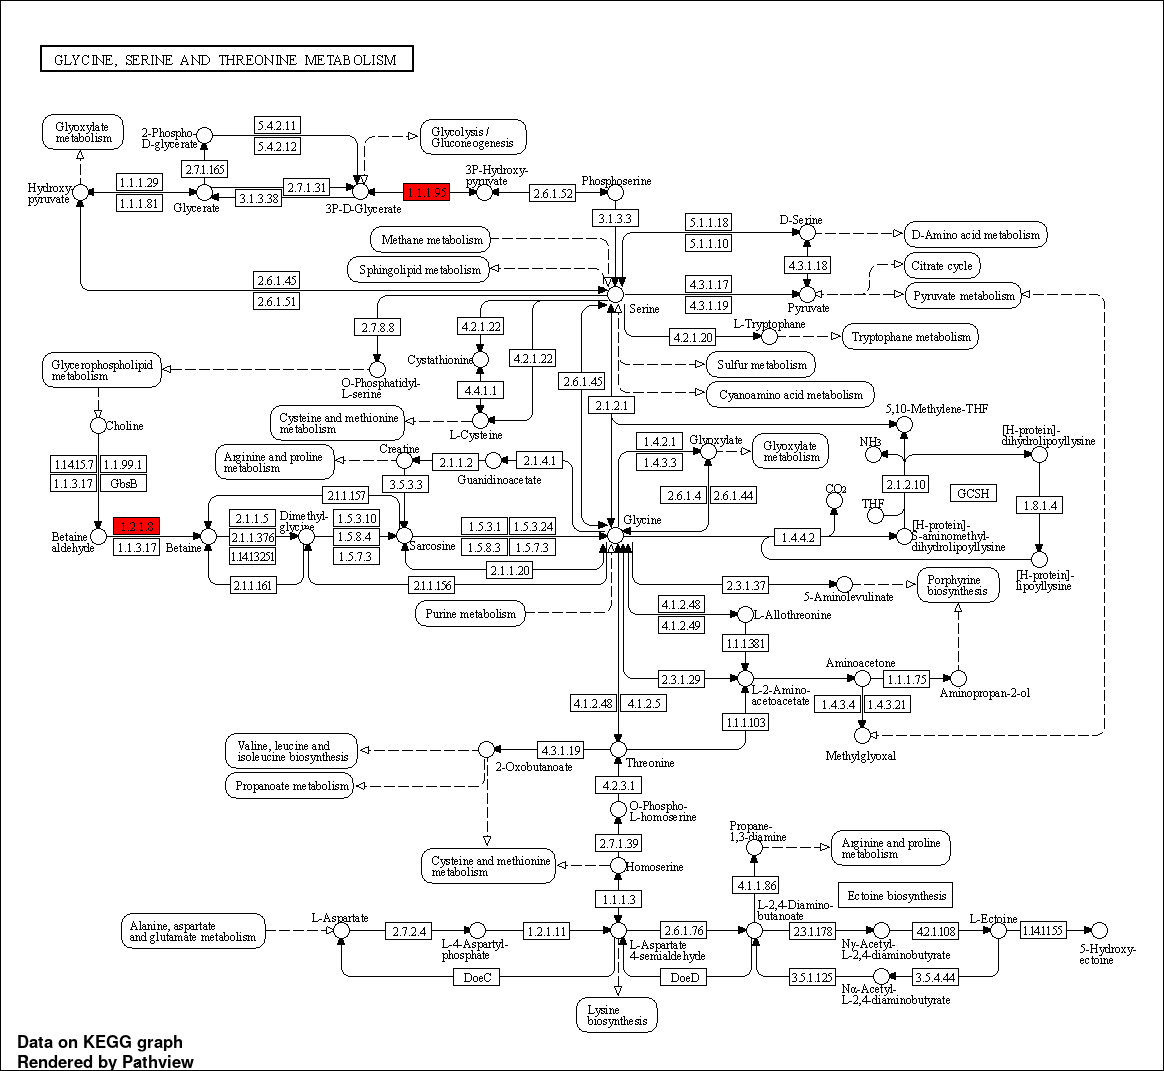

Finally, we visualized the High level GO categories obtained using [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/).

In [46]:
# reading file with High level GO categories (output of ShinyGo v0.77)
two_go_groups = pd.read_csv("../ala_two_loci/ant_ala_two_features/ant_ala_two_GO_groups.csv")
two_go_groups.head()

,N,High level GO category,Genes
0,15,Establishment of localization,100820282 100787870 100796349 100810009 100813...
1,12,Cellular component organization or biogenesis,100814240 100810009 100811312 100787806 100779...
2,11,Cellular component organization,100814240 100810009 100811312 100787806 100779...
3,9,Cellular response to stimulus,100817780 100779316 100790644 100812465 100816...
4,7,Catabolic process,100788208 100796349 100812650 100782483 100808...


In [47]:
# adding "\n" into string for visualization
two_go_groups.loc[:, "High level GO category"] = two_go_groups["High level GO category"].apply(parse_string)

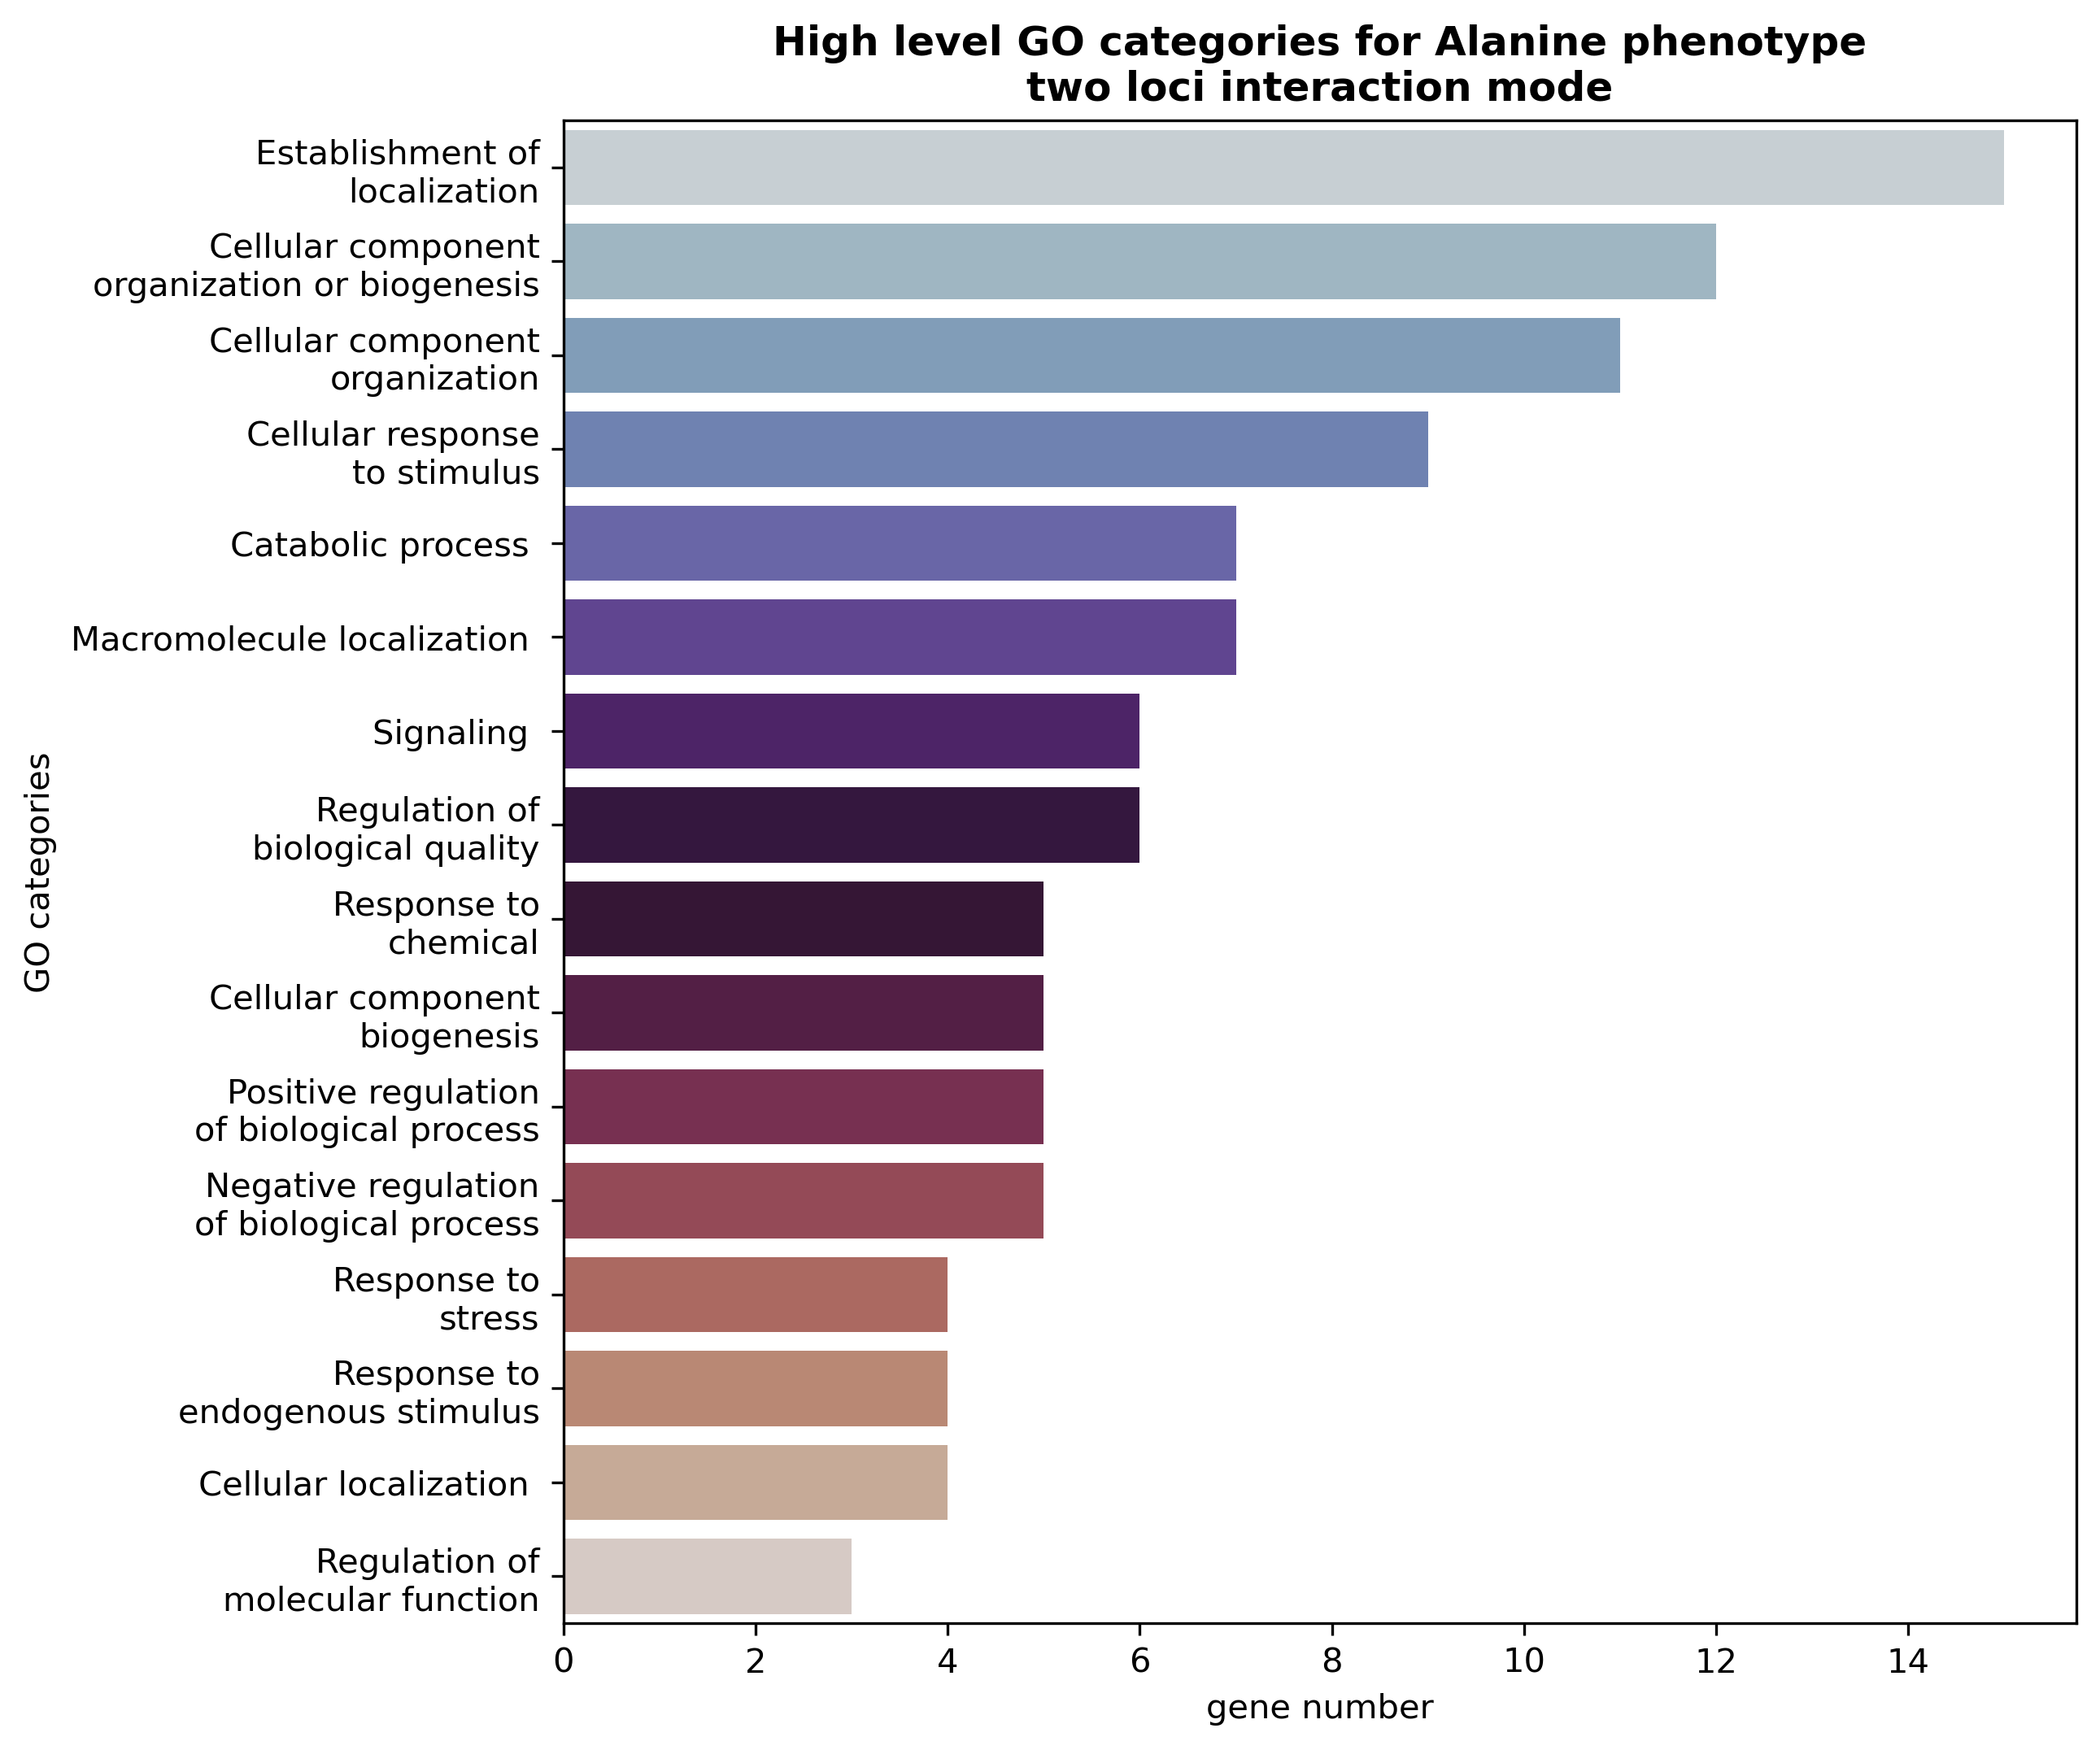

In [48]:
# barplot for High level GO category for two-loci interaction mode
fig, ax = plt.subplots(figsize=(8,8), dpi=300)
sns.barplot(data=two_go_groups[two_go_groups["N"] >= 3], x="N", y="High level GO category", ax=ax, palette="twilight")
plt.xlabel("gene number")
plt.ylabel("GO categories")
ax.set_title("High level GO categories for Alanine phenotype\ntwo loci interaction mode", fontsize=12, fontweight="bold")
plt.savefig("../Pictures/hl_GO_ala.png", format="png", bbox_inches="tight");

### Three loci interaction mode

The same analysis were performed for `AntEpiSeeker` *three-loci interaction* mode. 

**NOTE**: For description of parameters see [README.md](../README.md) section **AntEpiSeeker parameters**.

- **parameters.txt** for THREE LOCUS interaction Ala

| Parameter | Value | Description |
|-----------|:-----:|-------------|
| iAntCount | 1000  | number of ants |
| iItCountLarge | 735 | number of iterations for the large haplotypes |
| iItCountSmall | 1470  | number of iterations for the small haplotypes |
| alpha     | 1 | weight given to pheromone deposited by ants |
| iTopModel | 1000 | number of top ranking haplotypes in the first stage |
| iTopLoci  | 200 | number of loci with top ranking pheromone in the first stage |
| rou | 0.05 | evaporation rate in Ant Colony Optimizaion |
| phe | 100 | initial pheromone level for each locus |
| largehapsize | 6 | size of the large haplotypes | 
| smallhapsize | 4 | size of the small haplotypes |
| iEpiModel | 3 | number of SNPs in an epistatic interaction |
| pvalue | 0.01 | p value threshold (after Bonferroni correction) |
| INPFILE | ../ala_med_input/soybean012_ala_med.csv | input file name for case-control genotype data |
| OUTFILE | ../ala_three_loci/ant_result_Ala_med_three_loci.txt | output file name for detected epistatic interactions |

In [49]:
# reading file with results for alanine datasets and three-loci interaction mode
ant_ala_three = pd.read_csv(
    "../ala_three_loci/ant_result_Ala_med_three_loci.txt",
    sep='\t', skiprows=2, names=["Loci", "Chi-square", "p-value"]
)

# sorting dataframe by "Chi-square"
ant_ala_three.sort_values("Chi-square", ascending=False, ignore_index=True, inplace=True)

# splitting SNP pairs into three columns for convenience
ant_ala_three[["SNP1", "SNP2", "SNP3"]] = ant_ala_three.Loci.str.split(expand = True)
ant_ala_three.head()

,Loci,Chi-square,p-value,SNP1,SNP2,SNP3
0,13568(chr_19:35281163) 11887(chr_17:37389676) ...,50.2723,0.002917,13568(chr_19:35281163),11887(chr_17:37389676),10118(chr_15:33767340)
1,681(chr_01:41658240) 6411(chr_09:40211862) 143...,50.1562,0.003012,681(chr_01:41658240),6411(chr_09:40211862),14319(chr_20:34124529)
2,722(chr_01:45320366) 5489(chr_08:24450350) 647...,49.9845,0.003158,722(chr_01:45320366),5489(chr_08:24450350),6473(chr_09:42154383)
3,5(chr_01:292130) 3630(chr_05:41788665) 10364(c...,49.3889,0.003716,5(chr_01:292130),3630(chr_05:41788665),10364(chr_15:50733120)
4,719(chr_01:45320353) 5522(chr_08:26768161) 141...,48.0434,0.005340,719(chr_01:45320353),5522(chr_08:26768161),14187(chr_20:25544675)


#### Genome assembly remapping


There is no annotation for reference genome assembly v1.1. So, we need to remap our SNPs on genome assembly v2.1. For this we need to transform coordinates in this way:

1) add and substract 500bp from SNP position;
2) modify chromosome name from `chr_01` to `chr1`;
3) generate genome range in `chr13:35462025-35463025` format (`chrN:start-stop`)

OR

3) we can use `.bed` files for input

In [50]:
# generating dataframe with coordinates for each SNP in triplets
ant_ala_three = parse_snp_coord(dataframe=ant_ala_three, n_snps=3, remap=True)
ant_ala_three.head()

,Loci,Chi-square,p-value,SNP1,SNP2,SNP3,SNP1_chr,SNP1_pos,SNP2_chr,SNP2_pos,SNP3_chr,SNP3_pos
0,13568(chr_19:35281163) 11887(chr_17:37389676) ...,50.2723,0.002917,chr_19:35281163,chr_17:37389676,chr_15:33767340,chr19,35281163,chr17,37389676,chr15,33767340
1,681(chr_01:41658240) 6411(chr_09:40211862) 143...,50.1562,0.003012,chr_01:41658240,chr_09:40211862,chr_20:34124529,chr1,41658240,chr9,40211862,chr20,34124529
2,722(chr_01:45320366) 5489(chr_08:24450350) 647...,49.9845,0.003158,chr_01:45320366,chr_08:24450350,chr_09:42154383,chr1,45320366,chr8,24450350,chr9,42154383
3,5(chr_01:292130) 3630(chr_05:41788665) 10364(c...,49.3889,0.003716,chr_01:292130,chr_05:41788665,chr_15:50733120,chr1,292130,chr5,41788665,chr15,50733120
4,719(chr_01:45320353) 5522(chr_08:26768161) 141...,48.0434,0.005340,chr_01:45320353,chr_08:26768161,chr_20:25544675,chr1,45320353,chr8,26768161,chr20,25544675


In [51]:
# we decided to write SNP triplets (with IDs for each SNPs) in file to keep it as the result of AntEpiSeeker in more readable format
ant_ala_three.to_csv("../ala_three_loci/ala_med_snp_triplets.txt", columns=["SNP1", "SNP2", "SNP3"], 
                     header=True, index=False)

As was mentioned above, we generated 1kb region for each SNP for proper remapping on genome annotation v2.1. Also we split coordinates into three files. As we concidered, it turned out to be more convenient for further analysis.

In [52]:
# generating dataframe with SNP coordinates
ala_three_coords = ant_ala_three[["SNP1_chr", "SNP1_pos", "SNP2_chr", "SNP2_pos", "SNP3_chr", "SNP3_pos"]]

In [53]:
# path for saving 1kb regions
coord_path = "../ala_three_loci/ant_ala_three_coords/ala_three_snp500"

ala_three_coords = generate_1kb_regions(dataframe=ala_three_coords, n_snps=3, coord_file=coord_path)
ala_three_coords.head()

,SNP1_chr,SNP1_pos,SNP2_chr,SNP2_pos,SNP3_chr,SNP3_pos,SNP1+500,SNP1-500,coordinate1,SNP2+500,SNP2-500,coordinate2,SNP3+500,SNP3-500,coordinate3
0,chr19,35281163,chr17,37389676,chr15,33767340,35281663,35280663,chr19:35280663-35281663,37390176,37389176,chr17:37389176-37390176,33767840,33766840,chr15:33766840-33767840
1,chr1,41658240,chr9,40211862,chr20,34124529,41658740,41657740,chr1:41657740-41658740,40212362,40211362,chr9:40211362-40212362,34125029,34124029,chr20:34124029-34125029
2,chr1,45320366,chr8,24450350,chr9,42154383,45320866,45319866,chr1:45319866-45320866,24450850,24449850,chr8:24449850-24450850,42154883,42153883,chr9:42153883-42154883
3,chr1,292130,chr5,41788665,chr15,50733120,292630,291630,chr1:291630-292630,41789165,41788165,chr5:41788165-41789165,50733620,50732620,chr15:50732620-50733620
4,chr1,45320353,chr8,26768161,chr20,25544675,45320853,45319853,chr1:45319853-45320853,26768661,26767661,chr8:26767661-26768661,25545175,25544175,chr20:25544175-25545175


We obtained **eight interacting SNP triplets**.

Then we decided to perform feature remapping with [NCBI Feature remapping](https://www.ncbi.nlm.nih.gov/genome/tools/remap) web tool and following parameters:

| Parameter | Value |
|-----------|-------|
| **Genome information** | |
| Source Organism | Glycine max  |
| Source Assembly | V1.1 |
| Target Assembly | Glycine_max_v2.1 |
| **Remapping Options** | |
| Minimum ratio of bases that must be remapped:     | 0.5 |
| Maximum ratio for difference between source length and target length: | 2 |
| Allow multiple locations to be returned:  | yes |
| Merge Fragments: | no |
| **Data** | |
| Input format: | Best Guess |
| Output format: | Same as input | 

Then **Upload a file** or **Paste data**. The parameters were default, exept Assemblies and "Merge Fragments". We used genome assembly v2.1 because for this assembly there was a quite good annotation. Also, at the time of the analysis it was the latest reviewed assembly and it was in representative genome RefSeq category.

After [NCBI Feature remapping](https://www.ncbi.nlm.nih.gov/genome/tools/remap) information from V1.1 ([GCF_000004515.3](https://www.ncbi.nlm.nih.gov/assembly/GCF_000004515.3/)) to Glycine_max_v2.1 ([GCF_000004515.4](https://www.ncbi.nlm.nih.gov/assembly/GCF_000004515.5/)), we removed unmapped SNP regions for further analysis. This mean that the tool could not find defined regions from v1.1 in v2.1 genome assembly.

In [54]:
# reading the results of remapping
coords_snp1 = pd.read_csv("../ala_three_loci/ant_ala_three_coords/remapped_ala_three_snp500_1.xls", sep='\t', 
                          usecols=["mapped_id", "mapped_start", "mapped_stop"])
coords_snp2 = pd.read_csv("../ala_three_loci/ant_ala_three_coords/remapped_ala_three_snp500_2.xls", sep='\t', 
                          usecols=["mapped_id", "mapped_start", "mapped_stop"])
coords_snp3 = pd.read_csv("../ala_three_loci/ant_ala_three_coords/remapped_ala_three_snp500_3.xls", sep='\t', 
                          usecols=["mapped_id", "mapped_start", "mapped_stop"])

In [55]:
# checking the shape of dataframes with remapped coordinates, the number of rows should be 8 (number of SNP triplets)
coords_snp1.shape, coords_snp2.shape, coords_snp3.shape

((8, 3), (8, 3), (8, 3))

For further SNP annotation, we combined SNPs, found unique ones among them (in this case, it does not matter to us whether the SNP has met more than once in triplets), so for mapping SNPs on genes and analyze gene-gene interactions.

In [56]:
# combining SNPs from all triplets
snps_three = pd.concat([ant_ala_three["SNP1"], ant_ala_three["SNP2"], ant_ala_three["SNP3"]], axis=0).reset_index(drop=True)

In [58]:
print(f"Number of unique SNPs in triplets: {len(snps_three.unique())}")

Number of unique SNPs in triplets: 24


In [59]:
# generating dataframe with unique SNPs from triplets and their remapped coordinates
ant_ala_coords_three = pd.concat([coords_snp1, coords_snp2, coords_snp3], ignore_index=True, axis=0)
ant_ala_coords_three.loc[:, "SNP_IDs"] = snps_three
ant_ala_coords_three.head()

,mapped_id,mapped_start,mapped_stop,SNP_IDs
0,chr19,35466635,35467635,chr_19:35281163
1,chr1,42502302,42503302,chr_01:41658240
2,chr1,46191324,46192324,chr_01:45320366
3,chr1,291492,292492,chr_01:292130
4,chr1,46191311,46192311,chr_01:45320353


In [60]:
# checking the presence of unmapped regions containing SNPs
ant_ala_coords_three[ant_ala_coords_three["mapped_id"].isna()]

,mapped_id,mapped_start,mapped_stop,SNP_IDs


So, all regions were remapped on genome assembly v2.1.

#### Annotation

We need to annotate SNP triplets resulted from `AntEpiSeeker` tool. For this purpose, we replaced  chromosome names with those from annotation for [genome assembly v2.1](https://www.ncbi.nlm.nih.gov/assembly/GCF_000004515.5). The chromosome in this annotation are presented as RefSeq IDs (start with NC_).

In [61]:
# path for .bed file
bed_path = "../ala_three_loci/ant_ala_three_coords/ala_three_loci_coords_v21"

# generating .bed file for SNP annotation
ant_ala_coords_three = generate_bed_file_aa(dataframe=ant_ala_coords_three, chr_names_dict=chr_names, bed_path=bed_path)

In [62]:
# this dataframe was written in .bed file
ant_ala_coords_three.head()

,mapped_id,mapped_start,mapped_stop,SNP_IDs,chr_ID
0,chr19,35466634,35467634,chr_19:35281163,NC_038255.1
1,chr1,42502301,42503301,chr_01:41658240,NC_016088.3
2,chr1,46191323,46192323,chr_01:45320366,NC_016088.3
3,chr1,291491,292491,chr_01:292130,NC_016088.3
4,chr1,46191310,46192310,chr_01:45320353,NC_016088.3


To intersect genome regions contained SNPs with genome annotation v2.1, we run `bedtools intersect`:

```
bedtools intersect -wao -a ala_three_loci_coords_v21.bed -b GCF_000004515.5_Glycine_max_v2.1_genomic.gff > ../ala_three_loci/ant_ala_three_features/ala_three_loci_intersec.txt
```

#### Parsing features and filtering genes

After intersection with annotation file, we parsed resulted features and filtered genes.

In [63]:
# reading intersection file
# we only interested in columns with "SNP_ID", "chr", "type", "start", "stop", "features", "intersection_length"
ala_three_intersec = pd.read_csv("../ala_three_loci/ant_ala_three_features/ala_three_loci_intersec.txt", 
                         sep='\t', usecols=[3, 4, 6, 7, 8, 12, 13], header=None, 
                         names=["SNP_ID", "chr", "type", "start", "stop", "features", "intersection_length"])
ala_three_intersec.head()

,SNP_ID,chr,type,start,stop,features,intersection_length
0,chr_19:35281163,NC_038255.1,gene,35466405,35469330,ID=gene-LOC100775264;Dbxref=GeneID:100775264;N...,1000
1,chr_19:35281163,NC_038255.1,mRNA,35466405,35469330,ID=rna-XM_003553938.4;Parent=gene-LOC100775264...,1000
2,chr_19:35281163,NC_038255.1,exon,35466405,35467607,ID=exon-XM_003553938.4-2;Parent=rna-XM_0035539...,972
3,chr_19:35281163,NC_038255.1,CDS,35466610,35467607,ID=cds-XP_003553986.1;Parent=rna-XM_003553938....,972
4,chr_19:35281163,NC_038255.1,region,1,50746916,ID=NC_038255.1:1..50746916;Dbxref=taxon:3847;N...,1000


In [64]:
# filtering features with type "gene"
ala_three_genes = ala_three_intersec[ala_three_intersec["type"] == "gene"]

It is known that the genome annotation may contain more than one entry about a genomic region (for example, some genes may overlap, or a gene may be annotated by different algorithms). Therefore, we checked whether there are duplicates in our case.

In [65]:
# checking duplicated SNP_IDs
ala_three_genes[ala_three_genes["SNP_ID"].duplicated(keep=False)]

,SNP_ID,chr,type,start,stop,features,intersection_length


No duplicated SNP IDs.

The "features" column contains a lot of information. The most valuable for our analysis is "gene ID". We parsed "features" in the following way.

In [66]:
# parsing column "features" to obtain gene attibutes (especially gene IDs)
ala_three_genes_feat = parse_features(ala_three_genes["features"])
ala_three_genes_feat.head()

,ID,Dbxref,Name,gbkey,gene,gene_biotype
0,gene-LOC100775264,GeneID:100775264,LOC100775264,Gene,LOC100775264,protein_coding
1,gene-LOC100817780,GeneID:100817780,LOC100817780,Gene,LOC100817780,protein_coding
2,gene-LOC100780029,GeneID:100780029,LOC100780029,Gene,LOC100780029,protein_coding
3,gene-LOC100814240,GeneID:100814240,LOC100814240,Gene,LOC100814240,protein_coding
4,gene-LOC102670230,GeneID:102670230,LOC102670230,Gene,LOC102670230,protein_coding


In [67]:
# combining genes with respective SNPs
ala_three_genes_feat = pd.concat([ala_three_genes["SNP_ID"].reset_index(drop=True),
                                  ala_three_genes_feat[["Name", "gene_biotype"]]], axis=1)
ala_three_genes_feat.head()

,SNP_ID,Name,gene_biotype
0,chr_19:35281163,LOC100775264,protein_coding
1,chr_01:292130,LOC100817780,protein_coding
2,chr_17:12450639,LOC100780029,protein_coding
3,chr_01:43265761,LOC100814240,protein_coding
4,chr_09:40211862,LOC102670230,protein_coding


In [68]:
# dropping duplicated genes
ala_three_genes_feat_drop_dupl = ala_three_genes_feat.drop_duplicates(subset="Name", keep="first").reset_index(drop=True)
ala_three_genes_feat_drop_dupl.shape

(11, 3)

We have **11 genes** after SNP annotation, gene filtering, and dropping duplicated ones. It is known that Gene IDs for uncharechterized genes starts with *"LOC"*. But some web tools do not recognise them. For further analysis, we removed "LOC" from Gene IDs. 

In [69]:
# removing "LOC" from Gene IDs
ala_three_genes_feat_drop_dupl.loc[:, "genes"] = ala_three_genes_feat_drop_dupl["Name"].apply(lambda x: x[3:] if x.startswith("LOC") else x)

In [70]:
# saving all GeneIDs to file for further enrichment analysis
ala_three_genes_feat_drop_dupl.to_csv("../ala_three_loci/ant_ala_three_features/ala_three_loci_genes.txt", 
                                      columns=["genes"], header=None, index=False)

Further, we used [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/) web tool to performe GO and KEGG annotation for each SNP in pairs. As the result, we found to genes assiciated Glycine, serine and threonine metabolism ([KEGG:gmx00260](https://www.genome.jp/kegg-bin/show_pathway?gmx00260)). They are **chr_20:35966513** and **chr_06:16163675**. Next, we determined their pairs as follows.

#### GO and KEGG enrichment analysis

Next, we generated DataFrame with gene triplets based on SNP annotation (for each SNP in triplets we matched SNP ID with respective genes). As expected, we obtained 11 triplets.

In [71]:
# generating dictionary with SNP-gene pairs
snp_gene_dict = dict(zip(ala_three_genes_feat_drop_dupl["SNP_ID"], ala_three_genes_feat_drop_dupl["Name"]))
print(f"Number of SNP-gene triplets: {len(snp_gene_dict)}")

Number of SNP-gene triplets: 11


In [72]:
# copying initial DataFrame with SNP triplets
ala_gene_triplets = ant_ala_three[["SNP1", "SNP2", "SNP3", "Chi-square"]].copy()
ala_gene_triplets = assign_gene_for_snp(dataframe=ala_gene_triplets, n_snps=3, snp_gene_dict=snp_gene_dict)

In [73]:
ala_gene_triplets.head()

,SNP1,SNP2,SNP3,Chi-square,gene1,gene2,gene3
0,chr_01:292130,chr_05:41788665,chr_15:50733120,49.3889,LOC100817780,LOC100789887,LOC100798041


As the result of analysis, we identified **only one gene triplet** with probable epistatic interactions, for all of which SNPs there are recordings in annotation file.

| **SNP1 ID** | **gene** | **product ID** | **description** | **SNP2 ID** | **gene** | **product ID** | **description** | **SNP3 ID** | **gene** | **product ID** | **description** |
|:-------:|----------|:----------:|-------------|:-------:|----------|:----------:|-------------|:-------:|----------|:----------:|-------------|
| chr_01:292130 | LOC100817780 | XP_014619109.1 | auxin response factor 19 isoform X3 | chr_05:41788665 | LOC100789887 | XP_003524476.1 | uncharacterized protein LOC100789887 | chr_15:50733120 | LOC100798041 | XP_006598665.1 | uncharacterized protein LOC100798041 |

In [74]:
# saving SNP triplets with respective genes
ala_gene_triplets.to_csv("../ala_three_loci/ant_ala_three_features/ant_ala_three_loci_snps_genes.csv", index=False)

Further, we used [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/) webtools to perform GO and KEGG annotation for each SNP in triplets. As the result, we found only one gene associated with Glycine, serine and threonine metabolism ([KEGG:gmx00260](https://www.genome.jp/kegg-bin/show_pathway?gmx00260)). It is **chr_02:48342029**. Only one SNP **chr_02:48342029** was associated with amino acid metabolism. We decided to check other SNPs which comprise the triplet with **chr_02:48342029**. The results are shown below.

So, according to annotation, other SNPs from triplet lie outside the known protein coding genes or poorly characterized.

| **SNP1 ID** | **gene** | **product_ID** | **description** | **SNP2 ID** | **gene** | **product_ID** | **description** | **SNP3 ID** | **gene** | **product_ID** | **description** |
|:-------:|:----:|:----------:|:-----------:|:-------:|:---:|:----------:|:-----------:|:-------:|-----|:----------:|-------------|
| chr_10:44178196 | - | - | - | chr_10:14113197 | - | - | - | chr_02:48342029 | LOC100814810 |XP_003519448.1 | 1-aminocyclopropane-1-carboxylate oxidase |


**Cysteine and meteonine metabolism**

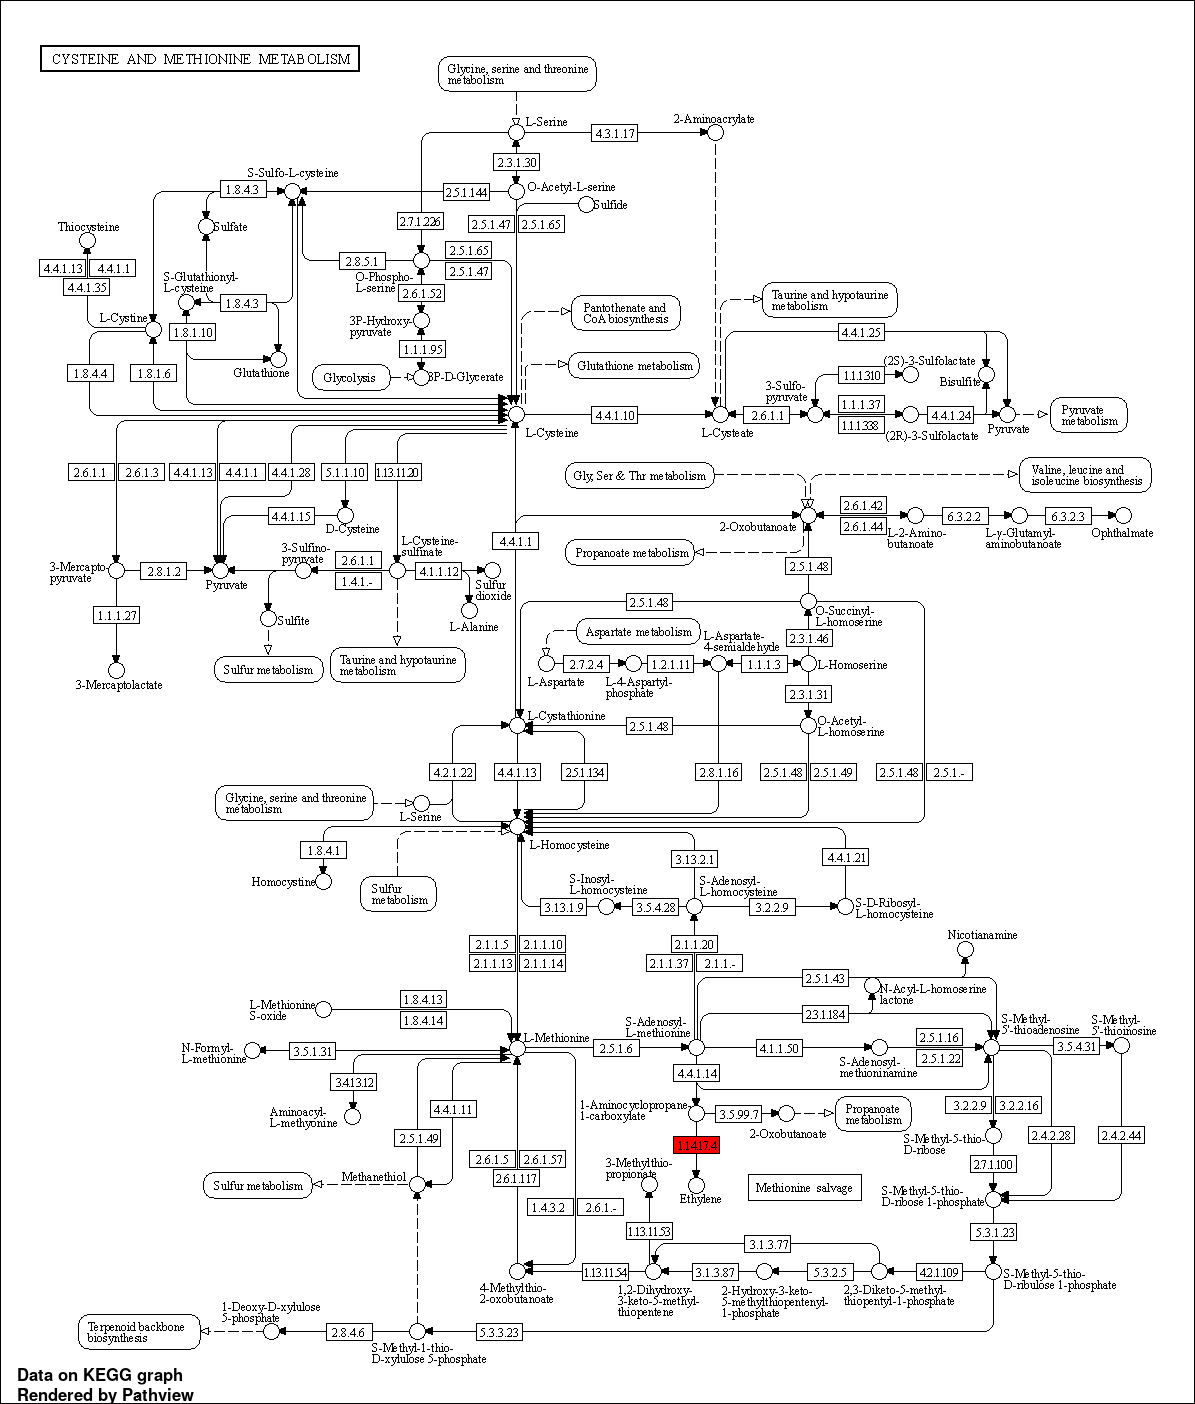

In [75]:
# description for "chr_10:44178196" variant
ala_three_intersec[ala_three_intersec["SNP_ID"] == "chr_10:44178196"]

,SNP_ID,chr,type,start,stop,features,intersection_length
26,chr_10:44178196,NC_038246.1,region,1,51566898,ID=NC_038246.1:1..51566898;Dbxref=taxon:3847;N...,1000


In [76]:
# description for "chr_10:14113197" variant
ala_three_intersec[ala_three_intersec["SNP_ID"] == "chr_10:14113197"]

,SNP_ID,chr,type,start,stop,features,intersection_length
59,chr_10:14113197,NC_038246.1,region,1,51566898,ID=NC_038246.1:1..51566898;Dbxref=taxon:3847;N...,1000


In [77]:
# description for "chr_02:48342029" variant
ala_three_intersec[
    (ala_three_intersec["SNP_ID"] == "chr_02:48342029") & (ala_three_intersec["type"] == "gene")]

,SNP_ID,chr,type,start,stop,features,intersection_length
88,chr_02:48342029,NC_016089.3,gene,45262297,45264174,ID=gene-LOC100814810;Dbxref=GeneID:100814810;N...,1000


Finally, we visualized the results of KEGG enrichment analysis via [ShinyGO 0.77](http://bioinformatics.sdstate.edu/go/).

In [78]:
# reading the results for KEGG enrichment analysis
three_kegg = pd.read_csv("../ala_three_loci/ant_ala_three_features/ala_three_loci_KEGG.csv")

three_kegg = parse_kegg_results(kegg_dataframe=three_kegg)

In [79]:
three_kegg.head()

,Enrichment FDR,nGenes,Pathway Genes,Fold Enrichment,Pathway,URL,Genes,KEGG_ID
0,1.5,1,78,65.148019,Flavonoid biosynthesis,http://www.genome.jp/kegg-bin/show_pathway?gmx...,100775264,Flavonoid biosynthesis:\ngmx00941
1,1.5,1,71,71.571063,Circadian rhythm,http://www.genome.jp/kegg-bin/show_pathway?gmx...,100775264,Circadian rhythm:\ngmx04712
2,1.4,1,154,32.997048,Cysteine and methionine metabolism,http://www.genome.jp/kegg-bin/show_pathway?gmx...,100814810,Cysteine and\nmethionine metabolism: gmx00270
3,1.3,2,1828,5.559678,Biosynthesis of secondary metabolites,http://www.genome.jp/kegg-bin/show_pathway?gmx...,100814810 100775264,Biosynthesis of\nsecondary metabolites: gmx01110


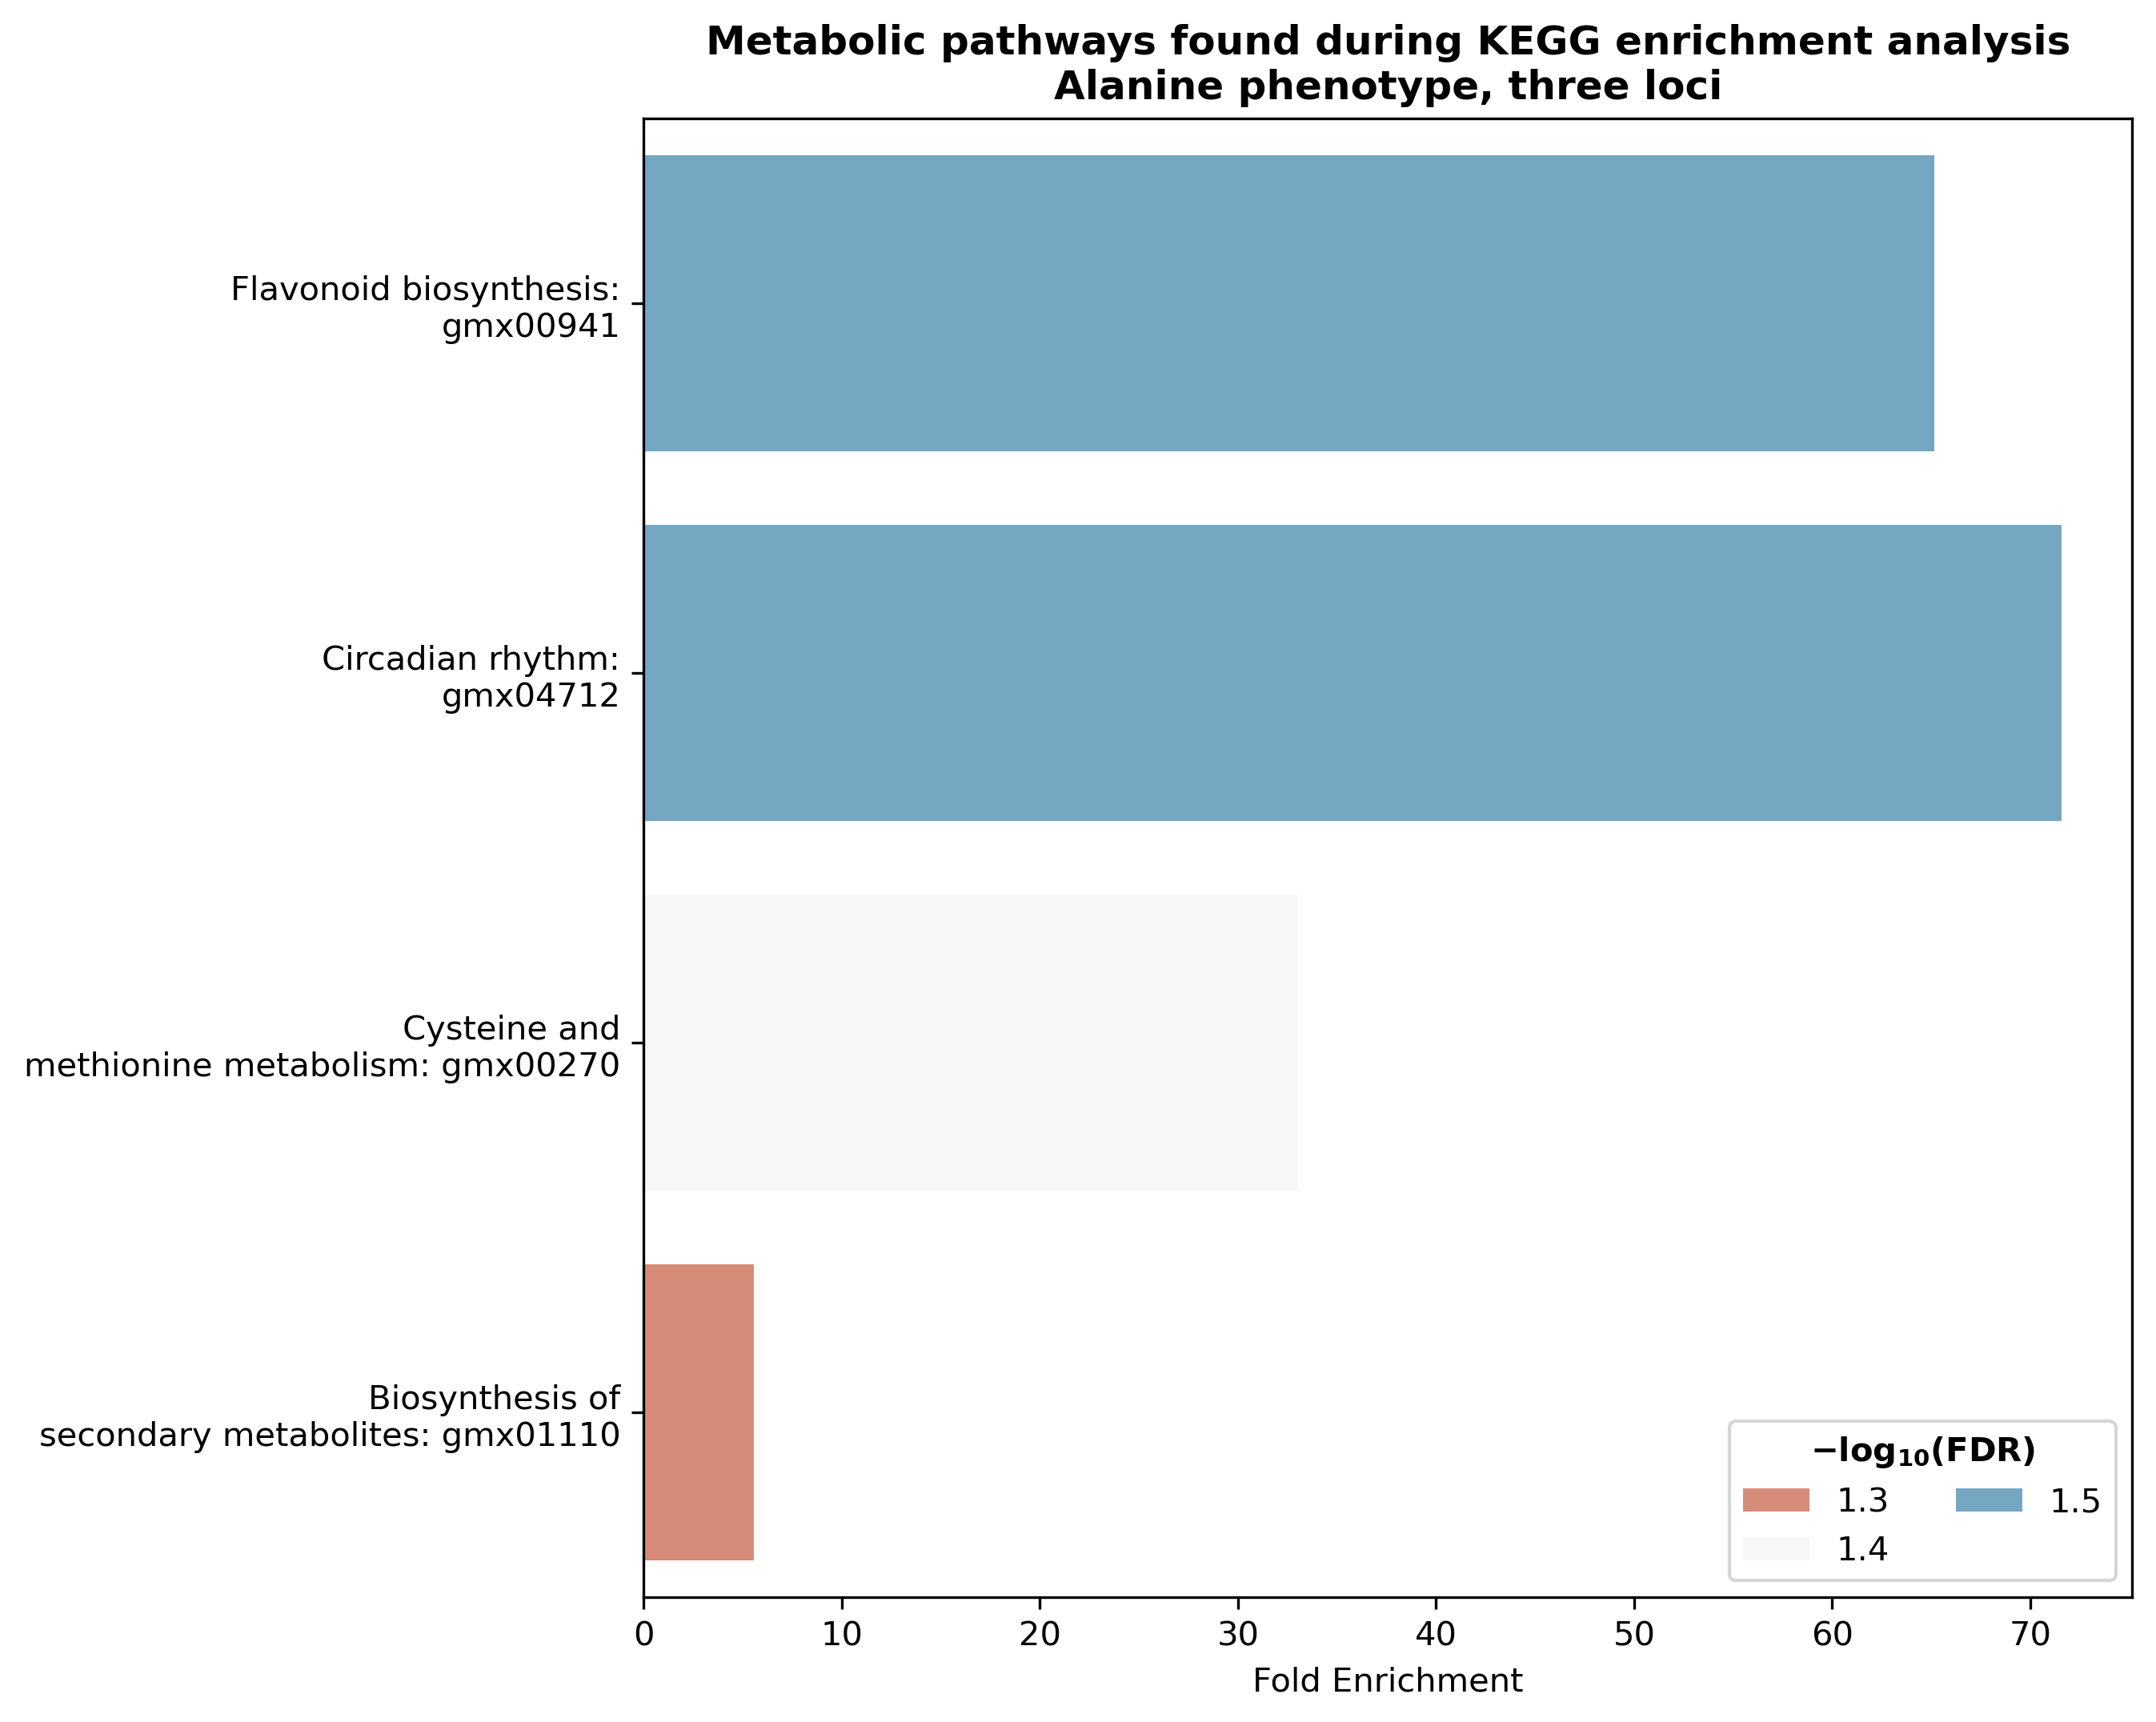

In [80]:
# barplot with KEGG Enrichment analysis results for three-loci interaction mode
fig, ax = plt.subplots(figsize=(8,8), dpi=300)
sns.barplot(data=three_kegg, x="Fold Enrichment", y="KEGG_ID", hue="Enrichment FDR", palette="RdBu", ax=ax, dodge=False)
ax.set_ylabel("")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, ncol=2, loc="lower right", 
          title="$\mathbf{-log_{10}(FDR)}$")
ax.set_title("Metabolic pathways found during KEGG enrichment analysis\nAlanine phenotype, three loci", fontsize=12, fontweight="bold")
plt.savefig("../Pictures/ala_three_KEGG.png", format="png", bbox_inches="tight");